# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [1]:
import random
import time
import torch
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from tensorly import tenalg
import tensorly as tl
from sklearn.metrics import mean_squared_error as mse

from time import time

torch.manual_seed(0)

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [2]:
def tensor_mul_mat(tensor, list_of_mat):
    """Возвращает произведение тензора на матрицы"""
    D = tensor.reshape(tensor.shape[0], -1)
    res = tl.matmul(tl.tensor(D.T), tl.tensor(list_of_mat[0].T)).reshape(tensor.shape[1], -1)
    res = tl.matmul(res.T, tl.tensor(list_of_mat[1].T)).reshape(tensor.shape[2], -1)
    res = tl.matmul(res.T, tl.tensor(list_of_mat[2].T)).reshape((list_of_mat[0].shape[0], 
                                                      list_of_mat[1].shape[0], 
                                                      list_of_mat[2].shape[0])) + np.random.normal(0.01, .1) # random noise
    return res

In [3]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150), r=(10, 20, 30)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = np.random.randint(0, 10, size=r).astype(np.double)
    U = []
    res = 0
    for i, size_i in enumerate(size):
        u = np.random.randint(0, 10, size=(size_i, r[i])).astype(np.double)
        U.append(u)
        
        
    res = tensor_mul_mat(G, U)
    
    return res, U, G

res, U, G = get_tensor()

In [4]:
res

array([[[3685947.86370457, 2850573.86370457, 3439015.86370457, ...,
         3095916.86370457, 2489537.86370457, 2691646.86370457],
        [5402119.86370456, 4193123.86370457, 5032522.86370456, ...,
         4554174.86370456, 3657769.86370457, 3929125.86370457],
        [1935121.86370457, 1508100.86370457, 1807707.86370457, ...,
         1645471.86370457, 1320504.86370457, 1428758.86370457],
        ...,
        [4297283.86370456, 3360854.86370457, 3993433.86370457, ...,
         3613914.86370457, 2895790.86370457, 3138906.86370457],
        [4198727.86370456, 3245812.86370457, 3923497.86370457, ...,
         3530738.86370457, 2854401.86370457, 3083153.86370457],
        [3602803.86370457, 2795755.86370457, 3367594.86370457, ...,
         3043570.86370457, 2443679.86370457, 2643382.86370457]],

       [[3598676.86370457, 2786422.86370457, 3364646.86370457, ...,
         3025568.86370457, 2439536.86370457, 2648741.86370457],
        [5271603.86370456, 4102999.86370457, 4914777.86370456

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [5]:
data, U, G = get_tensor(size=(10, 10, 10), r=(2, 2, 2))
data.shape, [u.shape for u in U], G.shape
data

array([[[1.48009983e+03, 2.31209983e+03, 2.61609983e+03, 3.20099831e+02,
         2.47209983e+03, 1.15209983e+03, 1.61609983e+03, 1.00009983e+03,
         8.40099831e+02, 2.29609983e+03],
        [1.41009983e+03, 2.27409983e+03, 2.38209983e+03, 2.40099831e+02,
         2.39409983e+03, 1.10409983e+03, 1.33209983e+03, 1.05009983e+03,
         9.30099831e+02, 2.14209983e+03],
        [3.01009983e+03, 4.80209983e+03, 5.16609983e+03, 5.60099831e+02,
         5.08209983e+03, 2.35209983e+03, 2.99609983e+03, 2.17009983e+03,
         1.89009983e+03, 4.60609983e+03],
        [3.60099831e+02, 6.48099831e+02, 5.04099831e+02, 9.98312195e-02,
         6.48099831e+02, 2.88099831e+02, 1.44099831e+02, 3.60099831e+02,
         3.60099831e+02, 5.04099831e+02],
        [1.91009983e+03, 2.99809983e+03, 3.35409983e+03, 4.00099831e+02,
         3.19809983e+03, 1.48809983e+03, 2.04409983e+03, 1.31009983e+03,
         1.11009983e+03, 2.95409983e+03],
        [2.39009983e+03, 3.86209983e+03, 4.02609983e+03, 4.0

## 2 Реализуйте метод для восстановления тензора по разложению

In [6]:
# Функция, восстанавливающая тензор по ядру и матрицам
def repair_tensor(G_, U):
    data = tensor_mul_mat(G_, U)
    # data - восстановленный тензор из матриц и ядра
    # U - список матриц
    # G_ - ядро разложения

    return data

In [7]:
rep_tensor = repair_tensor(G, U)
rep_tensor

array([[[ 1.47992076e+03,  2.31192076e+03,  2.61592076e+03,
          3.19920763e+02,  2.47192076e+03,  1.15192076e+03,
          1.61592076e+03,  9.99920763e+02,  8.39920763e+02,
          2.29592076e+03],
        [ 1.40992076e+03,  2.27392076e+03,  2.38192076e+03,
          2.39920763e+02,  2.39392076e+03,  1.10392076e+03,
          1.33192076e+03,  1.04992076e+03,  9.29920763e+02,
          2.14192076e+03],
        [ 3.00992076e+03,  4.80192076e+03,  5.16592076e+03,
          5.59920763e+02,  5.08192076e+03,  2.35192076e+03,
          2.99592076e+03,  2.16992076e+03,  1.88992076e+03,
          4.60592076e+03],
        [ 3.59920763e+02,  6.47920763e+02,  5.03920763e+02,
         -7.92372917e-02,  6.47920763e+02,  2.87920763e+02,
          1.43920763e+02,  3.59920763e+02,  3.59920763e+02,
          5.03920763e+02],
        [ 1.90992076e+03,  2.99792076e+03,  3.35392076e+03,
          3.99920763e+02,  3.19792076e+03,  1.48792076e+03,
          2.04392076e+03,  1.30992076e+03,  1.109920

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [8]:
def get_tensor_box(size=(100,200,150), r=(10, 20, 30)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = np.random.randint(0, 10, size=r).astype(np.double)
    U = []
    res = 0
    for i, size_i in enumerate(size):
        u = np.random.randint(0, 10, size=(size_i, r[i])).astype(np.double)
        U.append(u)
    

    res = tensor_mul_mat(G, U)
    
    data_box = tenalg.multi_mode_dot(G, U)
    
    return res, data_box

a1, a2 = get_tensor_box()
loss = np.linalg.norm(a1 - a2)
loss

31.5982752350272

Не забудьте померить ошибку разложения по метрике MSE

In [9]:
print('MSE:', mse(a1.flatten(), a2.flatten()))

MSE: 0.00033281699927611183


# HW 2 - Разложение матриц градиентным методом. Part 2

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [10]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Opt(Optimizer):

    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        
        if not self.state:
            self.state["step"] = 1
        else:
            self.state["step"] += 1

    
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad_param = param.grad.data
                param.data -= group['lr']*grad_param
        

        return loss

In [11]:
device = 'cuda'
tl.set_backend('pytorch')
t1 = time()
rep_tensor = tl.tensor(repair_tensor(G,U), device=device, requires_grad=True)
t2 = time()
rep_tensor

D:\anaconda\envs\fruitjuice\lib\site-packages\tensorly\backend\pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


tensor([[[1.4800e+03, 2.3120e+03, 2.6160e+03, 3.2004e+02, 2.4720e+03,
          1.1520e+03, 1.6160e+03, 1.0000e+03, 8.4004e+02, 2.2960e+03],
         [1.4100e+03, 2.2740e+03, 2.3820e+03, 2.4004e+02, 2.3940e+03,
          1.1040e+03, 1.3320e+03, 1.0500e+03, 9.3004e+02, 2.1420e+03],
         [3.0100e+03, 4.8020e+03, 5.1660e+03, 5.6004e+02, 5.0820e+03,
          2.3520e+03, 2.9960e+03, 2.1700e+03, 1.8900e+03, 4.6060e+03],
         [3.6004e+02, 6.4804e+02, 5.0404e+02, 3.7483e-02, 6.4804e+02,
          2.8804e+02, 1.4404e+02, 3.6004e+02, 3.6004e+02, 5.0404e+02],
         [1.9100e+03, 2.9980e+03, 3.3540e+03, 4.0004e+02, 3.1980e+03,
          1.4880e+03, 2.0440e+03, 1.3100e+03, 1.1100e+03, 2.9540e+03],
         [2.3900e+03, 3.8620e+03, 4.0260e+03, 4.0004e+02, 4.0620e+03,
          1.8720e+03, 2.2360e+03, 1.7900e+03, 1.5900e+03, 3.6260e+03],
         [1.2200e+03, 2.0200e+03, 1.9800e+03, 1.6004e+02, 2.1000e+03,
          9.6004e+02, 1.0000e+03, 9.8004e+02, 9.0004e+02, 1.8200e+03],
         [7.9

In [12]:
ranks = [10, 10, 10]
core = tl.tensor(torch.randint(0, 10, (ranks)).double(), device=device, requires_grad=True)
factors = [tl.tensor(torch.randint(0, 10, (rep_tensor.shape[i], ranks[i])).double(), device=device, requires_grad=True) 
           for i in range(np.ndim(rep_tensor))]

In [13]:
[i.shape for i in factors]

[torch.Size([10, 10]), torch.Size([10, 10]), torch.Size([10, 10])]

In [14]:
core.shape

torch.Size([10, 10, 10])

In [15]:
n_iter = 6000
lr = 0.00001
penalty = 0.1
points = []
errors = []

optimizer = Opt([core]+factors, lr=lr)

for i in range(n_iter + 1):
    # reset grad
    optimizer.zero_grad()

    # decomposed form-->tensor
    rec = tenalg.multi_mode_dot(core, factors)

    # squared l2 loss(Squared Error Loss)
    loss = tl.sqrt(tl.norm(rec - rep_tensor)**2)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        rec_error = torch.norm(rec.data - rep_tensor.data, 2) / torch.norm(rep_tensor.data, 2)
        errors.append(rec_error)
        points.append(i)
        print("Epoch {},. Rec. error: {}".format(i, rec_error))

Epoch 0,. Rec. error: 149.8352813720703
Epoch 100,. Rec. error: 0.7158940434455872
Epoch 200,. Rec. error: 0.4585336446762085
Epoch 300,. Rec. error: 0.3328978419303894
Epoch 400,. Rec. error: 0.25977790355682373
Epoch 500,. Rec. error: 0.20859745144844055
Epoch 600,. Rec. error: 0.17055746912956238
Epoch 700,. Rec. error: 0.14158932864665985
Epoch 800,. Rec. error: 0.1191926971077919
Epoch 900,. Rec. error: 0.10170730203390121
Epoch 1000,. Rec. error: 0.08797888457775116
Epoch 1100,. Rec. error: 0.07716874033212662
Epoch 1200,. Rec. error: 0.06864051520824432
Epoch 1300,. Rec. error: 0.061893872916698456
Epoch 1400,. Rec. error: 0.05652782693505287
Epoch 1500,. Rec. error: 0.05222081393003464
Epoch 1600,. Rec. error: 0.048718295991420746
Epoch 1700,. Rec. error: 0.04582252725958824
Epoch 1800,. Rec. error: 0.043382447212934494
Epoch 1900,. Rec. error: 0.04128400981426239
Epoch 2000,. Rec. error: 0.03944157809019089
Epoch 2100,. Rec. error: 0.037790730595588684
Epoch 2200,. Rec. error:

In [16]:
t3 = time()
print('repair time:', t2 - t1)
print('grad time:', t3 - t2)
print(rec, rep_tensor)

repair time: 0.23200106620788574
grad time: 21.128001928329468
tensor([[[ 1.5084e+03,  2.4054e+03,  2.6374e+03,  2.8218e+02,  2.5114e+03,
           1.1585e+03,  1.6575e+03,  1.0502e+03,  8.5375e+02,  2.3081e+03],
         [ 1.4519e+03,  2.2821e+03,  2.4329e+03,  2.4943e+02,  2.4383e+03,
           1.1081e+03,  1.3595e+03,  1.0510e+03,  9.2990e+02,  2.2101e+03],
         [ 3.0755e+03,  4.8477e+03,  5.2943e+03,  6.0722e+02,  5.1841e+03,
           2.3971e+03,  3.0762e+03,  2.1809e+03,  1.9064e+03,  4.7340e+03],
         [ 3.6442e+02,  5.9625e+02,  5.2736e+02,  6.4146e+01,  7.0647e+02,
           3.2000e+02,  1.3638e+02,  3.3916e+02,  3.9233e+02,  5.3009e+02],
         [ 1.9358e+03,  3.0925e+03,  3.4300e+03,  4.0670e+02,  3.2538e+03,
           1.5321e+03,  2.0985e+03,  1.3492e+03,  1.1359e+03,  3.0006e+03],
         [ 2.4500e+03,  3.8910e+03,  4.1191e+03,  4.5171e+02,  4.1442e+03,
           1.9088e+03,  2.2871e+03,  1.8000e+03,  1.6326e+03,  3.7246e+03],
         [ 1.2557e+03,  2.0296e

       device='cuda:0', grad_fn=<PermuteBackward0>) tensor([[[1.4800e+03, 2.3120e+03, 2.6160e+03, 3.2004e+02, 2.4720e+03,
          1.1520e+03, 1.6160e+03, 1.0000e+03, 8.4004e+02, 2.2960e+03],
         [1.4100e+03, 2.2740e+03, 2.3820e+03, 2.4004e+02, 2.3940e+03,
          1.1040e+03, 1.3320e+03, 1.0500e+03, 9.3004e+02, 2.1420e+03],
         [3.0100e+03, 4.8020e+03, 5.1660e+03, 5.6004e+02, 5.0820e+03,
          2.3520e+03, 2.9960e+03, 2.1700e+03, 1.8900e+03, 4.6060e+03],
         [3.6004e+02, 6.4804e+02, 5.0404e+02, 3.7483e-02, 6.4804e+02,
          2.8804e+02, 1.4404e+02, 3.6004e+02, 3.6004e+02, 5.0404e+02],
         [1.9100e+03, 2.9980e+03, 3.3540e+03, 4.0004e+02, 3.1980e+03,
          1.4880e+03, 2.0440e+03, 1.3100e+03, 1.1100e+03, 2.9540e+03],
         [2.3900e+03, 3.8620e+03, 4.0260e+03, 4.0004e+02, 4.0620e+03,
          1.8720e+03, 2.2360e+03, 1.7900e+03, 1.5900e+03, 3.6260e+03],
         [1.2200e+03, 2.0200e+03, 1.9800e+03, 1.6004e+02, 2.1000e+03,
          9.6004e+02, 1.0000e+03

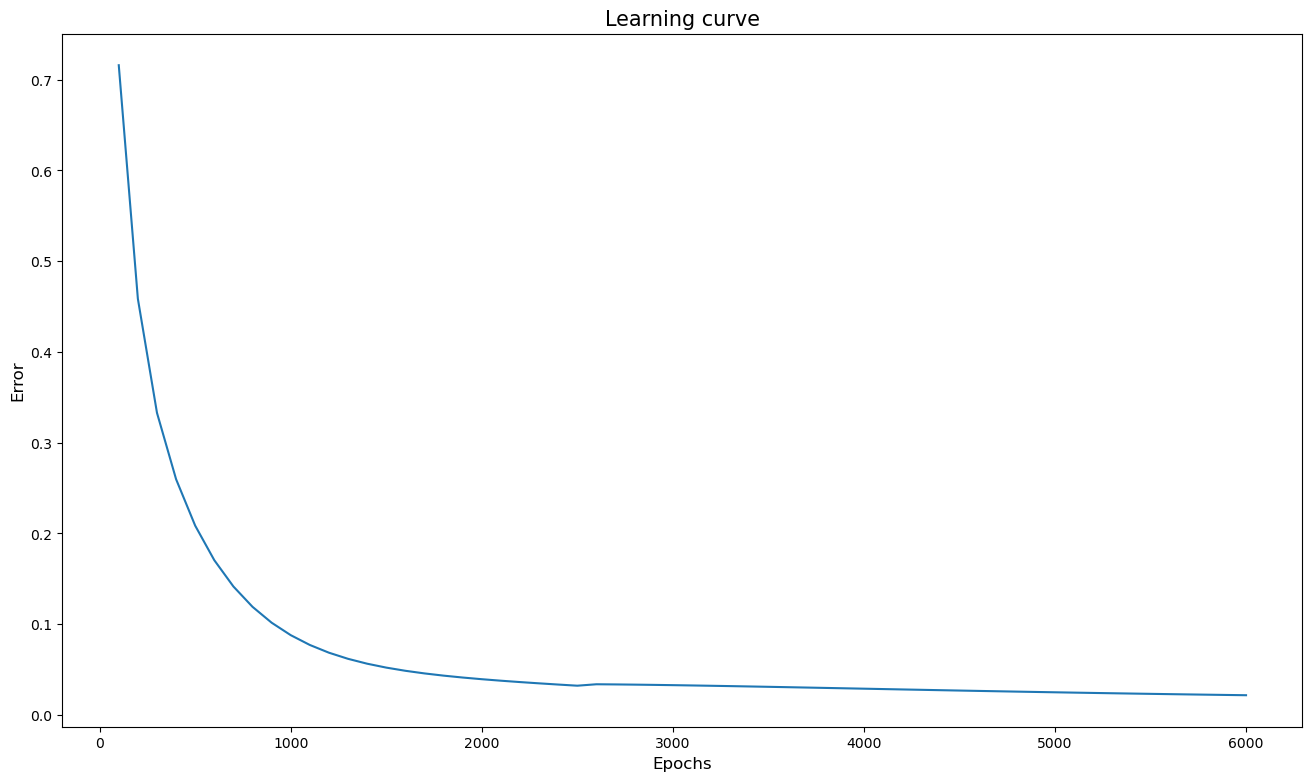

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title('Learning curve', fontsize=15)
plt.plot(points[1:], [er.tolist() for er in errors[1:]])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)

plt.show()